$$
\frac{d\psi}{d{x}}=\exp(\frac{-x^2}{2})\cdot sin(x)-\psi
$$
$$
\text{when }  x=0,  \psi=0
$$

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


In [ ]:
# N is a Neural Network
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))


# The Psi_t function: what neural network will approximate
def Psi_t(x):
    return N(x)


# The right hand side function
def f(x, Psi):
    return torch.exp(-x**2 / 2.0) * torch.sin(x) - Psi

# The loss function
def loss(x):
    x.requires_grad = True
    outputs = Psi_t(x)
    Psi_t_x = torch.autograd.grad(outputs, x, grad_outputs=torch.ones_like(outputs),
                                  create_graph=True)[0]
    x0 = torch.tensor([[0.0]], requires_grad=True)  # Explicit x = 0
    Psi_x0 = Psi_t(x0)                              # initial condition
    return torch.mean((Psi_t_x - f(x, outputs)) ** 2 + 0.5*(Psi_t(x0) - 0)**2)

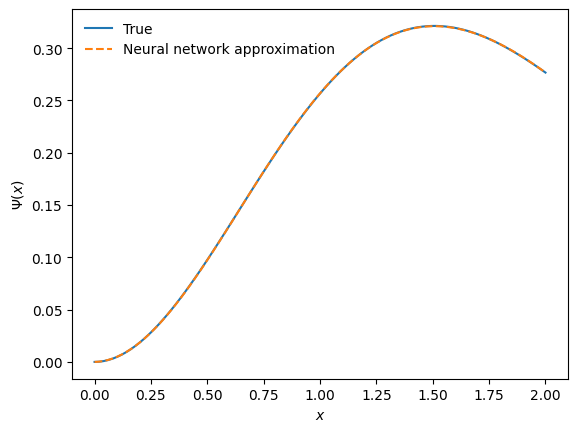

In [ ]:
# Optimize
optimizer = torch.optim.LBFGS(N.parameters())

# The collocation points
x = torch.Tensor(np.linspace(0, 2, 100)[:, None])
# reshaped from (100,) to (100,1)

# the closer function is required by LBFGS optimizer
def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()
    return l

#iterate 10 times to update network parameter
for i in range(10):
    optimizer.step(closure)

# Initial conditions
x_start = 0  # Starting x value
x_end = 2   # Ending x value for the solution
Psi_0 = 0    # Initial condition Psi(0) = Psi_0

# Define the ODE function for analytical solution
def dPsi_dx(x, Psi):
    return np.exp(-x**2 / 2.0) * np.sin(x) - Psi
solution = solve_ivp(dPsi_dx, [x_start, x_end], [Psi_0], dense_output=True)


# Plotting the solution
x_values = np.linspace(x_start, x_end, 100)
Psi_values = solution.sol(x_values)[0]


#disable gradient tracking, which is unnecessary for plotting results.
with torch.no_grad():
    yy = Psi_t(torch.Tensor(x_values)[:, None]).numpy()




fig, ax = plt.subplots(dpi=100)
ax.plot(x_values, Psi_values, label='True')
ax.plot(x_values, yy, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(frameon=False)

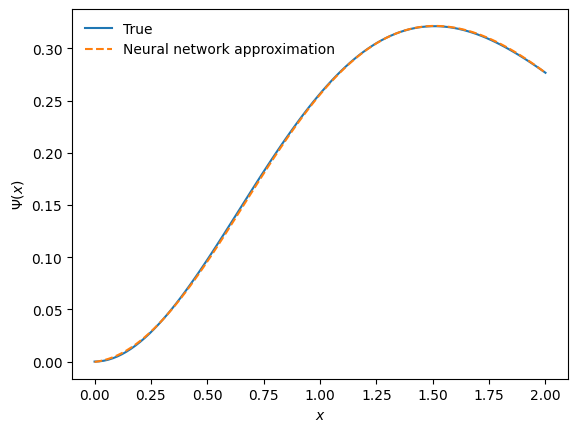

In [ ]:
# We need to reinitialize the network
N = nn.Sequential(nn.Linear(1, 50), nn.Sigmoid(), nn.Linear(50,1, bias=False))

# Now trying stochastic optimizer
adam = torch.optim.Adam(N.parameters(), lr=0.01)

# The batch size: similar to mini batch in stochastic gradient descent.
n_batch = 10

# The maximum number of iterations to do
max_it = 1000

for i in range(max_it):
    # scales x to [0,2)
    x = 2 * torch.rand(n_batch, 1)
    # Zero-out the gradient buffers
    adam.zero_grad()
    # Evaluate the loss: the function we defined earlier
    l = loss(x)
    l.backward()
    # Update the network
    adam.step()



with torch.no_grad():
    y_g = Psi_t(torch.Tensor(x_values)[:, None]).numpy()


fig, ax = plt.subplots(dpi=100)
ax.plot(x_values,Psi_values, label='True')
ax.plot(x_values,y_g, '--', label='Neural network approximation')
ax.set_xlabel('$x$')
ax.set_ylabel('$\Psi(x)$')
plt.legend(frameon=False)

$$
\frac{d^2y}{dx^2}=-4x
$$

$$
y(-1)=0\text{ ; }y(1)=0
$$

$$
\text{solution = } \frac{-2(x^3-x)}{3}
$$

In [ ]:
class Network2(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer = nn.Linear(1, 10)
        self.output_layer = nn.Linear(10, 1)

    def forward(self, x):
        layer_out = torch.sigmoid(self.hidden_layer(x))
        output = self.output_layer(layer_out)
        return output

N2 = Network2()

In [ ]:
def g(x):
    return 4*x*-torch.ones(x.shape[0], x.shape[1])

def loss(x):
    x.requires_grad = True
    y = N2(x)
    dy_dx = torch.autograd.grad(y.sum(), x, create_graph=True)[0]
    y_double_prime = torch.autograd.grad(dy_dx.sum(), x, create_graph=True)[0]

    return torch.mean( (y_double_prime - g(x))**2 ) + 0.5*(y[0, 0] - 0)**2 + 0.5*(y[-1, 0] - 0)**2

In [ ]:
optimizer = torch.optim.LBFGS(N2.parameters())

x = torch.linspace(-1, 1, 100)[:, None]

def closure():
    optimizer.zero_grad()
    l = loss(x)
    l.backward()

    return l

epochs = 100
for i in range(epochs):
    optimizer.step(closure)

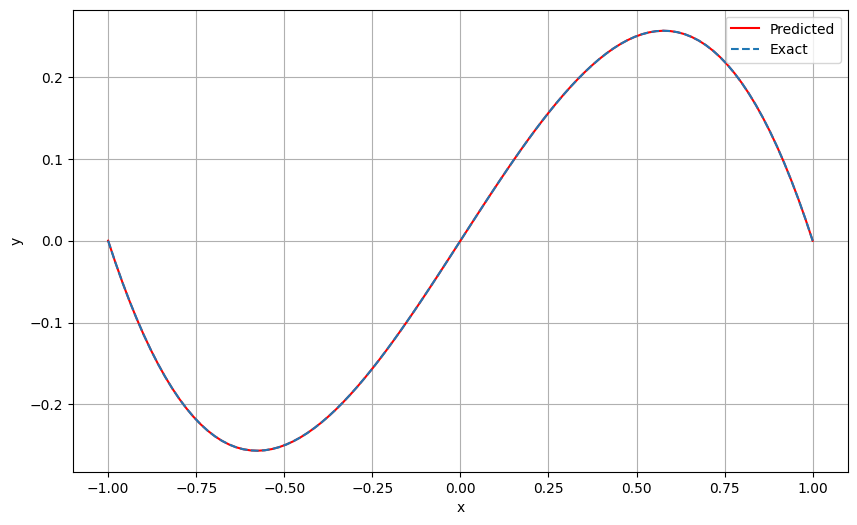

In [ ]:

xx = torch.linspace(-1, 1, 100)[:, None]
with torch.no_grad():
    yy = N2(xx)

plt.figure(figsize=(10, 6))
plt.plot(xx, yy, label="Predicted",color='red')
plt.plot(xx, (-4/6)*(xx**3-xx), '--', label="Exact")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()